In [ ]:
#|default_exp n1d_embedding_analysis
import numpy as np
import matplotlib.pyplot as plt
import deepdish

import os
os.environ["GEOMSTATS_BACKEND"] = "pytorch"

# models
import torch
from autometric.autoencoders import DistanceMatchingAutoencoder
from autometric.datasets import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1d Embedding Analysis

What can the autometrics tell us? This goes to the heart of the project - and, in this notebook, we develop the tools based on the metrics.

These tools come in two flavors:
1. Analysis of the encoder. The pullback metric here is less rich, but can still be revealing.
2. Analysis of the decoder. Here, insofar as the decoder accurately reconstructs the data, we're guaranteed a proper metric. We can then analyze features of this metric independently, such as how often volume changes, or how 'chaotic' the reconstruction is.

# Encoder Analysis

## Eigenvalues of the Metric

Each eigenvalue represents the degree of preservation applied to each direction in the ambient space under the embedding, where $1$ is total preservation, and $0.1$ means it's being compressed by a factor of 10. 

In [ ]:
#|export
from autometric.metrics import PullbackMetric
import numpy as np
import torch
def determinants_of_encoder_pullback(model, dataloader):
    # returns the determinants of the metric matrices for each point in the dataset
    Metric = PullbackMetric(model.input_dim, model.encoder)
    Gs = Metric.metric_matrix(dataloader.dataset.pointcloud).detach().cpu().numpy()
    dets = [np.linalg.det(G) for G in Gs]
    return np.array(dets)

INFO: Using pytorch backend


In [ ]:
#|export
from autometric.metrics import PullbackMetric
import numpy as np
import torch
def trace_of_encoder_pullback(model, dataloader):
    # returns the determinants of the metric matrices for each point in the dataset
    Metric = PullbackMetric(model.input_dim, model.encoder)
    Gs = Metric.metric_matrix(dataloader.dataset.pointcloud).detach().cpu().numpy()
    dets = [np.sum(np.linalg.eigvals(G)) for G in Gs]
    return np.array(dets)

In [ ]:
#|export
from autometric.metrics import PullbackMetric
import numpy as np
import torch
def rank_of_encoder_pullback(model, dataloader, eps=1e-10):
    # returns the determinants of the metric matrices for each point in the dataset
    Metric = PullbackMetric(model.input_dim, model.encoder)
    Gs = Metric.metric_matrix(dataloader.dataset.pointcloud).detach().cpu().numpy()
    ranks = [np.sum((np.linalg.eigvals(G)>eps).astype(int)) for G in Gs]
    return np.array(ranks)

In [ ]:
#|export
from autometric.metrics import PullbackMetric
import numpy as np
import torch
def spectral_entropy_of_matrix(A):
    # returns the spectral entropy of a matrix
    # A is a numpy array
    eigvals = np.linalg.eigvals(A)
    eigvals = eigvals[eigvals > 0]
    eigvals /= eigvals.sum()
    return -np.sum(eigvals * np.log(eigvals))

def spectral_entropy_of_encoder_pullback(model, dataloader):
    # returns the determinants of the metric matrices for each point in the dataset
    Metric = PullbackMetric(model.input_dim, model.encoder)
    Gs = Metric.metric_matrix(dataloader.dataset.pointcloud).detach().cpu().numpy()
    entropies = [spectral_entropy_of_matrix(G) for G in Gs]
    return np.array(entropies)

In [ ]:
#|export
def evals_of_encoder_pullback(model, dataloader):
    # returns the determinants of the metric matrices for each point in the dataset
    Metric = PullbackMetric(model.input_dim, model.encoder)
    Gs = Metric.metric_matrix(dataloader.dataset.pointcloud).detach().cpu().numpy()
    e = [np.sort(np.linalg.eigvals(G))[::-1] for G in Gs]
    return np.vstack(e)

In [ ]:
#|export
def smallest_eigenvector(matrix):
    """
    Find the eigenvector associated with the smallest eigenvalue of a square matrix.

    Args:
        matrix (np.array): A square numpy array representing a matrix.

    Returns:
        np.array: The eigenvector associated with the smallest eigenvalue.
    """
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(matrix)

    # Find the index of the smallest eigenvalue
    min_index = np.argmin(eigenvalues)

    # Return the corresponding eigenvector
    return eigenvectors[:, min_index]
def normal_vectors_of_encoder_pullback(model, dataloader):
    # returns the determinants of the metric matrices for each point in the dataset
    Metric = PullbackMetric(model.input_dim, model.encoder)
    Gs = Metric.metric_matrix(dataloader.dataset.pointcloud).detach().cpu().numpy()
    e = [smallest_eigenvector(G) for G in Gs]
    return np.vstack(e)

We'll wrap all of these metrics into a convenient form so they can be run en-masse on a single model, without having to specify each of them.

In [ ]:
#|export
import matplotlib.pyplot as plt
import numpy
from autometric.utils import *
from mpl_toolkits.mplot3d import Axes3D

def visualize_encoder_pullback_metrics(model, dataloader, title):
    X = model.encoder(dataloader.dataset.pointcloud).cpu().detach().numpy()
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))

    spectral_entropy = spectral_entropy_of_encoder_pullback(model,dataloader)
    axs[0,0].scatter(X[:,0],X[:,1],c=spectral_entropy)
    axs[0,0].set_title("Spectral Entropy")

    trace = trace_of_encoder_pullback(model,dataloader)
    axs[0,1].scatter(X[:,0],X[:,1],c=trace)
    axs[0,1].set_title("Trace")

    rank = rank_of_encoder_pullback(model,dataloader)
    axs[0,2].scatter(X[:,0],X[:,1],c=rank)
    axs[0,2].set_title("Rank")
    
    evals = evals_of_encoder_pullback(model, dataloader)
    for i in range(3):
        axs[1,i].scatter(X[:,0],X[:,1],c=evals[:,i])
        axs[1,i].set_title(f"{printnum(i)} Eigenvalue")
    
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

In [ ]:
#|export
import matplotlib.pyplot as plt
import numpy
from autometric.utils import *
from mpl_toolkits.mplot3d import Axes3D

def visualize_encoder_pullback_metrics_in_ambient_space(model, dataloader, title):
    X = model.encoder(dataloader.dataset.pointcloud).cpu().detach().numpy()
    D = dataloader.dataset.pointcloud.cpu().detach().numpy()
    figure = plt.figure()

    ax = figure.add_subplot(231, projection='3d')
    spectral_entropy = spectral_entropy_of_encoder_pullback(model,dataloader)
    ax.scatter(D[:,0],D[:,1],D[:,2],c=spectral_entropy)
    ax.set_title("Spectral Entropy")

    ax = figure.add_subplot(232, projection='3d')
    trace = trace_of_encoder_pullback(model,dataloader)
    ax.scatter(D[:,0],D[:,1],D[:,2],c=trace)
    ax.set_title("Trace")

    ax = figure.add_subplot(233, projection='3d')
    rank = rank_of_encoder_pullback(model,dataloader)
    ax.scatter(D[:,0],D[:,1],D[:,2],c=rank)
    ax.set_title("Rank")
    
    evals = evals_of_encoder_pullback(model, dataloader)
    for i in range(3):
        ax = figure.add_subplot(230+i+4, projection='3d')
        ax.scatter(D[:,0],D[:,1],D[:,2],c=evals[:,i])
        ax.set_title(f"{printnum(i)} Eigenvalue")
    
    figure.suptitle(title)
    plt.show()

# Decoder Analysis

## Indicatrices
Defined as the set of embedding points mapping to a unit sphere, the indicatrices indicate directions and degrees of local distortion.

Mathematically, they are simply the 

In [ ]:
#|export
from autometric.util import *
from autometric.connections import LeviCivitaConnection
from autometric.metrics import PullbackMetric
from autometric.manifolds import RiemannianManifold
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

def plot_indicatrices(
                    model,
                    dataloader,
                    grid="convex_hull",
                    device="cpu",
                    num_steps=20,
                    num_gon=50,
                    output_path=None,
                    writer=None,
                    latent_activations=None,
                    model_name="GeomReg",
                    dataset_name="MNIST",
                    labels=None,
                    cmap="tab10",
                    just_on_data = False,
                    scaling_factor = 1/4
                    ):
    if latent_activations is None:
        pointcloud = dataloader.dataset.pointcloud
        try:
            latent_activations = model.encoder(dataloader.dataset.pointcloud).cpu().detach()
        except AttributeError:
            latent_activations = model.encode(dataloader.dataset.pointcloud).cpu().detach()

    generator = torch.Generator().manual_seed(0)
    perm = torch.randperm(labels.shape[0], generator=generator)
    
    latent_activations = latent_activations[perm]
    labels = labels[perm]

    coordinates_on_data = get_coordinates(torch.squeeze(latent_activations),
                                          grid="on_data",
                                          num_steps=num_steps,
                                          coords0=None,
                                          dataset_name=dataset_name,
                                          model_name=model_name).to(device)

    coordinates_off_data = get_coordinates(torch.squeeze(latent_activations),
                                           grid="off_data",
                                           num_steps=num_steps,
                                           coords0=None,
                                           dataset_name=dataset_name,
                                           model_name=model_name).to(device)

    if just_on_data:
        coordinates = coordinates_on_data
    else:
        coordinates = torch.vstack([coordinates_on_data, coordinates_off_data])

    # calculate grid step sizes
    x_min = torch.min(latent_activations[:, 0]).item()
    x_max = torch.max(latent_activations[:, 0]).item()
    y_min = torch.min(latent_activations[:, 1]).item()
    y_max = torch.max(latent_activations[:, 1]).item()

    num_steps_x = num_steps
    num_steps_y = int((y_max - y_min) / (x_max - x_min) * num_steps_x)

    step_size_x = (x_max - x_min) / (num_steps_x)
    step_size_y = (y_max - y_min) / (num_steps_y)
    stepsize = min(step_size_x, step_size_y)

    # # find initial coordinate
    # if coords0 is not None:
    #     coords0_index = None
    #     for i, row in enumerate(coordinates.cpu()):
    #         if torch.all(row.eq(coords0)):
    #             coords0_index = i
    coords0_index = 0
    coords0 = latent_activations[0]

    # initialize diffgeo objects
    # TODO: Equip for arbitrary dimensions
    pbm = PullbackMetric(2, model.decoder)
    lcc = LeviCivitaConnection(2, pbm)
    rm = RiemannianManifold(2, (1, 1), metric=pbm, connection=lcc)

    # generate vector patches at grid points, normed in pullback metric
    try:
        vector_patches, norm_vectors = rm.generate_unit_vectors(num_gon, coordinates)
    except RuntimeError:
        vector_patches, norm_vectors = rm.generate_unit_vectors(num_gon, coordinates.unsqueeze(-1).unsqueeze(-1))

    vector_patches = vector_patches.to(device)

    vector_norms = torch.linalg.norm(vector_patches.reshape
                                     (-1, 2), dim=1)
    max_vector_norm = torch.min(vector_norms[torch.nonzero(vector_norms)])

    normed_vector_patches = vector_patches / max_vector_norm * stepsize * scaling_factor  # / 3
    anchored_vector_patches = coordinates.unsqueeze(1).expand(*normed_vector_patches.shape) + normed_vector_patches

    # create polygons
    polygons = [Polygon(tuple(vector.tolist()), closed=True) for vector in anchored_vector_patches]

    polygons_on_data = polygons[:coordinates_on_data.shape[0]]
    polygons_off_data = polygons[coordinates_on_data.shape[0]:]


    if coords0 is not None:
        polygon0 = polygons.pop(coords0_index)

    """
    Plotting
    """
    
    latent_activations = latent_activations.detach().cpu()

    # plot blobs
    fig, ax = plt.subplots(figsize=(5, 5))

    ax.set_aspect("equal")
    ax.axis("off")
    fig.tight_layout(pad=0.)
    plt.margins(0.01, 0.01)

    ax.scatter(latent_activations[:, 0],
               latent_activations[:, 1],
               c=labels,
               cmap=cmap,
               **get_sc_kwargs())

    p_on_data = PatchCollection(polygons_on_data)
    p_off_data = PatchCollection(polygons_off_data)
    # p2 = PatchCollection(polygons2)

    # p_off_data.set_edgecolor([0 / 255, 0 / 255, 0 / 255, 0.2])
    # if model_name == "Vanilla" and dataset_name == "Zilionis":
    #    p_off_data.set_facecolor([0 / 255, 0 / 255, 0 / 255, 0.0])
    # else:
    #    p_off_data.set_facecolor([0 / 255, 0 / 255, 0 / 255, 0.2])

    p_on_data.set_color([0 / 255, 0 / 255, 0 / 255, 0.3])
    p_off_data.set_color([0 / 255, 0 / 255, 0 / 255, 0.3])

    if coords0 is not None:
        polygon0.set_color([255 / 255, 0 / 255, 0 / 255, 0.2])
        ax.add_patch(polygon0)

    ax.add_collection(p_off_data)
    ax.add_collection(p_on_data)
    ax.set_aspect("equal")
    ax.axis("off")
    # fig.suptitle(f"Indicatrices")

    if output_path is not None:
        plt.savefig(output_path, **get_saving_kwargs())

    plt.show()

    if writer is not None:
        writer.add_figure("indicatrix", fig)

        # clean up tensorboard writer
        writer.flush()
        writer.close()

Testing the above

In [ ]:
# instantiate a pytorch lightning trainer and train DerrickTheAutoencoder on the sphere dataset
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
import torch
from autometric.autoencoders import DerrickTheAutoencoder
import os
from autometric.datasets import PointcloudDataset

from diffusion_curvature.datasets import sphere, torus

In [ ]:
early_stopping = EarlyStopping('val_loss', patience=500)
trainer = Trainer(max_epochs=1000, 
                #   accelerator='cuda',
                  callbacks=[early_stopping])
model = DerrickTheAutoencoder(input_dim=3, intrinsic_dimension=2)
# check if model alreaady exists at ../data/sphere_encoder.pt - if so, load it
if os.path.exists('../data/sphere_encoder.pt'):
    model.load_state_dict(torch.load('../data/sphere_encoder.pt'))
else:
    trainer.fit(
        model=model,
        train_dataloaders=trainloader,
        val_dataloaders=valloader
    )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/piriac/mambaforge/envs/autometric/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [ ]:
X_sphere, ks_sphere = sphere(n=10000)
train_dataset = PointcloudDataset(X_sphere)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

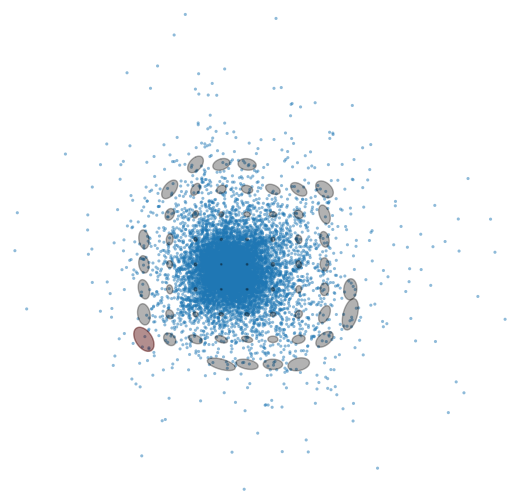

In [ ]:
plot_indicatrices(model, trainloader, labels = ks_sphere, scaling_factor=1/40, just_on_data=True)

## Fred Herschel's Indicatrix Volume Variance Metric

Measures the change in indicatrix volume across the manifold.

In [ ]:
#|export
def indicatrix_volume_variance_metric(
    model,
    dataloader,
):
    pointcloud = dataloader.dataset.pointcloud
    try:
        latent_activations = model.encoder(dataloader.dataset.pointcloud).cpu().detach()
    except AttributeError:
        latent_activations = model.encode(dataloader.dataset.pointcloud).cpu().detach()
    # set up manifold
    pbm = PullbackMetric(2, model.decoder)
    lcc = LeviCivitaConnection(2, pbm)
    rm = RiemannianManifold(2, (1, 1), metric=pbm, connection=lcc)
    # calculate the logarithm of the generalized jacobian determinant
    log_dets = rm.metric_logdet(base_point=latent_activations)
    # replace nan values with a small number
    #EPSILON = 1e-9
    #torch.nan_to_num(log_dets, nan=EPSILON, posinf=EPSILON, neginf=EPSILON)
    torch.nan_to_num(log_dets, nan=1., posinf=1., neginf=1.) # ?? TODO Investigate replacement of eps by 1
    # calculate the variance of the logarithm of the generalized jacobian determinant
    raw_loss = torch.var(log_dets)
    return raw_loss

In [ ]:
indicatrix_volume_variance_metric(model, trainloader)

/home/piriac/mambaforge/envs/autometric/lib/python3.11/site-packages/torch/_functorch/deprecated.py:88: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacfwd is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacfwd instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacfwd')
/home/piriac/mambaforge/envs/autometric/lib/python3.11/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecat

tensor(10.0560, grad_fn=<VarBackward0>)

## A Frequency of Volume Variance Metric

Like the above, but allows for variance in volume at low frequencies by comparing changes across an embedded graph of points.
We reason that what most distorts embeddings is high-frequency changes in volume scaling.

In [ ]:
#|export
from diffusion_curvature.kernels import gaussian_kernel
import pygsp

def frequency_of_volume_variance(
    model,
    dataloader,
    k=5, # k-nn graph
    alpha=1, # degree of anisotropic density normalization
):
    pointcloud = dataloader.dataset.pointcloud
    try:
        latent_activations = model.encoder(dataloader.dataset.pointcloud).cpu().detach()
    except AttributeError:
        latent_activations = model.encode(dataloader.dataset.pointcloud).cpu().detach()
    
    # construct a graph out of these latent_activations
    W = gaussian_kernel(
        latent_activations.numpy(),
        kernel_type='adaptive',
        k = k,
        anisotropic_density_normalization = alpha,
    )
    G = pygsp.graphs.Graph(W)
    
    # set up manifold
    pbm = PullbackMetric(2, model.decoder)
    lcc = LeviCivitaConnection(2, pbm)
    rm = RiemannianManifold(2, (1, 1), metric=pbm, connection=lcc)
    # calculate the logarithm of the generalized jacobian determinant
    log_dets = rm.metric_logdet(base_point=latent_activations)
    # replace nan values with a small number
    EPSILON = 1e-9
    torch.nan_to_num(log_dets, nan=EPSILON, posinf=EPSILON, neginf=EPSILON)
    log_dets = log_dets.detach().cpu().numpy()

    # compute quadric form of laplacian
    quadric_form = log_dets @ G.L @ log_dets.T
    return quadric_form

In [ ]:
frequency_of_volume_variance(model, trainloader)

2024-03-05 12:40:41,448:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
/home/piriac/mambaforge/envs/autometric/lib/python3.11/site-packages/torch/_functorch/deprecated.py:88: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacfwd is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacfwd instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacfwd')
/home/piriac/mambaforge/envs/autometric/lib/python3.11/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/

760.0614104647213

In [ ]:
%notebook save
!nbdev_export